In [6]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np


In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
transform = transforms.Compose([transforms.Resize(size=(128, 128)),transforms.ToTensor()])
trainset = torchvision.datasets.FGVCAircraft(
    root="./data",
    split="train",
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset,
    batch_size=4,
    shuffle=True
)

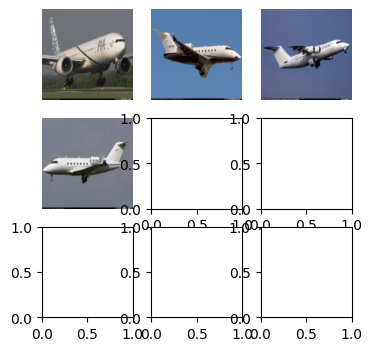

In [9]:
def display_images(images):
    figs, axes = plt.subplots(3, 3, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i].permute(1, 2, 0).numpy()
            ax.imshow(image)
            ax.axis("off")
    plt.show()

data, target = next(iter(trainloader))
images = data[:9]

display_images(images)

## Model

In [5]:
class DVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super(DVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.encoder_output = nn.Conv2d(256, embedding_dim, kernel_size=1)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        nn.init.xavier_normal(self.embeddings.weight)
        
        self.decoder_input = nn.Conv2d(embedding_dim, 256, kernel_size=1)

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()            
        )

    def encode(self, x):
        x = self.encoder(x)
        z = self.encoder_output(x)
        return z
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def vector_quantize(self, z):
        B, C, H, W = z.shape #(B, embedding_dim, 4, 4)
        z_flattened = z.permute(0, 2, 3, 1).reshape(-1, C) #(B*16, embedding_dim)
        distances = (z_flattened.unsqueeze(1) - self.embeddings.weight.unsqueeze(0)).pow(2).sum(-1)
        encoding_indices = distances.argmin(1) #(B*16,)
        
        z_q = self.embeddings(encoding_indices).view(B, H, W, C).permute(0, 3, 1, 2)
        z_q = z_q + (z - z_q).detach()

        return z_q, encoding_indices.view(B, H, W)       
        

    def forward(self, x):
        z = self.encode(x)
        z_q, encoding_indices = self.vector_quantize(z)
        recon_x = self.decode(z_q)

        commitment_loss = F.mse_loss(z, z_q.detach())
        codebook_loss = F.mse_loss(z.detach(), z_q)
        loss = commitment_loss + codebook_loss

        p = encoding_indices.view(-1).bincount(minlength=self.num_embeddings).float() + 1e-6
        p /= p.sum()  # Normalize to a probability distribution
        entropy_loss = - (p * p.log()).sum()  # Encourage uniform code use
        loss -= entropy_loss  # Subtracting makes it a regularization term
        
        return recon_x, loss, encoding_indices
        

In [6]:
latent_dim = 1024
model = DVAE(num_embeddings=4096, embedding_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

/tmp/ipykernel_61569/3032646540.py:18: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.embeddings.weight)


In [7]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

print(f"Model Size: {get_model_size(model)/1e6}M parmeters")

Model Size: 1.907715M parmeters


In [8]:
def loss_fn(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(
        recon_x,
        x,
        reduction="sum"
    )
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_div

In [9]:
from tqdm import tqdm

epochs = 60
best_loss = float("inf")
patience = 4
patience_counter = 0
best_model_dict = {}

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for i, (data, _) in enumerate(trainloader):
        data = data.to(device).float()

        optimizer.zero_grad()
        recon_data, commitment_loss, encoding_indices = model(data)

        recon_loss = F.mse_loss(recon_data, data)
        loss = recon_loss + commitment_loss
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(trainloader)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        if best_loss not in best_model_dict:
            best_model_dict[best_loss] = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter == patience:
            print(f"No improvement in loss for lost: {patience_counter} epochs")
            break
            
    print(f"Epoch: {epoch} || Average Loss: {epoch_loss}")
torch.save(f"ARTIFACTS/vqvae_cifar10_{best_loss}.pth", best_model_dict[best_loss])
    

Epoch: 0 || Average Loss: -1.529759017111872
Epoch: 1 || Average Loss: -1.1750723887123258
Epoch: 2 || Average Loss: -1.3300315066055357
Epoch: 3 || Average Loss: -1.5719676401903875
Epoch: 4 || Average Loss: -0.9641610799389121
Epoch: 5 || Average Loss: -0.795788835142002
Epoch: 6 || Average Loss: -1.0809743041232647
No improvement in loss for lost: 4 epochs


AttributeError: expected 'f' to be string, path, or a file-like object with a 'write' attribute

In [ ]:
-1.529759017111872 > -3.1

True

: 

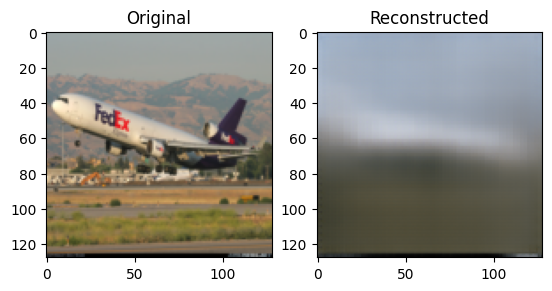

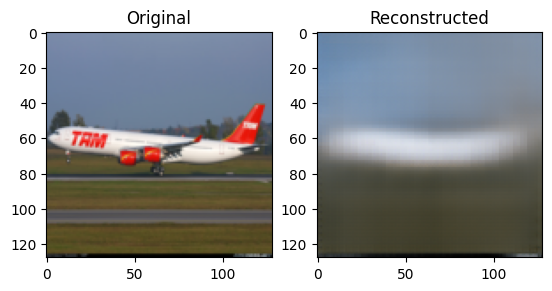

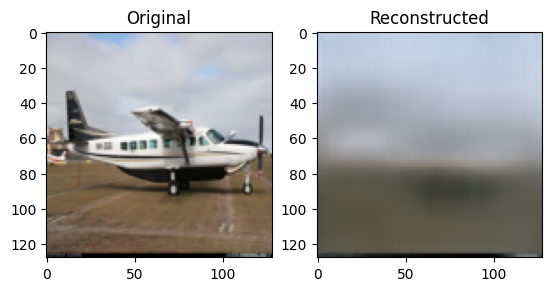

In [10]:
# Display some reconstructed images
def show_images(original, reconstructed):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())  # Convert tensor to image
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title("Reconstructed")
    plt.show()

model = torch.load("ARTIFACTS/VQVAE/best_model_vqvae_epoch_4.pth", map_location=device, weights_only=False)
model.eval()
for _ in range(3):
  # Test reconstruction on a sample
  test_img, _ = next(iter(trainloader))
  test_img = test_img.to(device)
  with torch.no_grad():
      reconstructed_img = model(test_img)[0]

  show_images(test_img[0], reconstructed_img[0])

In [20]:
batch_of_images, _ = next(iter(trainloader))
batch_of_images = batch_of_images.to(device)

recon_x, loss, encoding_indices = model(batch_of_images)
encoding_indices.unique()

tensor([  30, 1329, 2076, 2108, 2289, 2688, 3004, 3595, 4065], device='cuda:0')

In [21]:
svhn_dataset = torchvision.datasets.SVHN(root="./data", split="test", transform=transform, download=True)
svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=64, shuffle=True)

In [ ]:
# Display some reconstructed images
def show_images(original, reconstructed):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())  # Convert tensor to image
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title("Reconstructed")
    plt.show()

for _ in range(3):
  # Test reconstruction on a sample
  test_img, _ = next(iter(svhn_loader))
  test_img = test_img.to(device)
  with torch.no_grad():
      reconstructed_img = model(test_img)[0]

  show_images(test_img[0], reconstructed_img[0])

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 GiB. GPU 0 has a total capacity of 7.60 GiB of which 6.85 GiB is free. Process 2714 has 102.55 MiB memory in use. Including non-PyTorch memory, this process has 378.00 MiB memory in use. Of the allocated memory 187.58 MiB is allocated by PyTorch, and 68.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [ ]:
import torch

In [ ]:
checkpoint = torch.load("checkpoints/dvae-epoch=13-val_loss=0.06.ckpt")

In [ ]:
from models.modelling_dvae import DVAE, DVAEConfig, EncoderConfig, DecoderConfig, KLSchedConfig, TempSchedConfig

global_config = DVAEConfig(
    image_size=224,
    hidden_size=64,
    encoder=EncoderConfig(
        input_channels=3, output_channels=512, num_layers=2, num_resnet_blocks=2
    ),
    decoder=DecoderConfig(
        num_layers=2,
        num_resnet_blocks=2,
        input_channels=512,
        output_channels=3,
    ),
    num_embeddings=512,
    embedding_dim=512,
    temperature=0.9,
    learning_rate=5e-4,
    learning_rate_scheduler_min=1e-2,
    kl_div_scheduler=KLSchedConfig(
        start=0.0,
        end=1.0,
        warmup=0.1,
        cooldown=0.2,
    ),
    temperature_scheduler=TempSchedConfig(
        start=0.9, end=0.00625, warmup=0.0, cooldown=0.2
    ),
    batch_size=512,
    max_epochs=50,
)

model = DVAE(global_config)
model.load_state_dict(checkpoint["state_dict"])

/home/tensorthiru/vaes/models/modelling_dvae.py:199: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.embeddings.weight)


RuntimeError: Error(s) in loading state_dict for DVAE:
	Missing key(s) in state_dict: "encoder.layers.0.weight", "encoder.layers.0.bias", "encoder.layers.1.conv1.weight", "encoder.layers.1.conv1.bias", "encoder.layers.1.conv2.weight", "encoder.layers.1.conv2.bias", "encoder.layers.1.norm1.weight", "encoder.layers.1.norm1.bias", "encoder.layers.1.norm1.running_mean", "encoder.layers.1.norm1.running_var", "encoder.layers.1.norm2.weight", "encoder.layers.1.norm2.bias", "encoder.layers.1.norm2.running_mean", "encoder.layers.1.norm2.running_var", "encoder.layers.2.conv1.weight", "encoder.layers.2.conv1.bias", "encoder.layers.2.conv2.weight", "encoder.layers.2.conv2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm1.running_mean", "encoder.layers.2.norm1.running_var", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias", "encoder.layers.2.norm2.running_mean", "encoder.layers.2.norm2.running_var", "encoder.layers.3.weight", "encoder.layers.3.bias", "encoder.layers.5.conv1.weight", "encoder.layers.5.conv1.bias", "encoder.layers.5.conv2.weight", "encoder.layers.5.conv2.bias", "encoder.layers.5.norm1.weight", "encoder.layers.5.norm1.bias", "encoder.layers.5.norm1.running_mean", "encoder.layers.5.norm1.running_var", "encoder.layers.5.norm2.weight", "encoder.layers.5.norm2.bias", "encoder.layers.5.norm2.running_mean", "encoder.layers.5.norm2.running_var", "encoder.layers.6.conv1.weight", "encoder.layers.6.conv1.bias", "encoder.layers.6.conv2.weight", "encoder.layers.6.conv2.bias", "encoder.layers.6.norm1.weight", "encoder.layers.6.norm1.bias", "encoder.layers.6.norm1.running_mean", "encoder.layers.6.norm1.running_var", "encoder.layers.6.norm2.weight", "encoder.layers.6.norm2.bias", "encoder.layers.6.norm2.running_mean", "encoder.layers.6.norm2.running_var", "encoder.layers.7.weight", "encoder.layers.7.bias", "encoder.layers.9.weight", "encoder.layers.9.bias", "decoder.layers.0.weight", "decoder.layers.0.bias", "decoder.layers.1.conv1.weight", "decoder.layers.1.conv1.bias", "decoder.layers.1.conv2.weight", "decoder.layers.1.conv2.bias", "decoder.layers.1.norm1.weight", "decoder.layers.1.norm1.bias", "decoder.layers.1.norm1.running_mean", "decoder.layers.1.norm1.running_var", "decoder.layers.1.norm2.weight", "decoder.layers.1.norm2.bias", "decoder.layers.1.norm2.running_mean", "decoder.layers.1.norm2.running_var", "decoder.layers.2.conv1.weight", "decoder.layers.2.conv1.bias", "decoder.layers.2.conv2.weight", "decoder.layers.2.conv2.bias", "decoder.layers.2.norm1.weight", "decoder.layers.2.norm1.bias", "decoder.layers.2.norm1.running_mean", "decoder.layers.2.norm1.running_var", "decoder.layers.2.norm2.weight", "decoder.layers.2.norm2.bias", "decoder.layers.2.norm2.running_mean", "decoder.layers.2.norm2.running_var", "decoder.layers.3.weight", "decoder.layers.3.bias", "decoder.layers.5.conv1.weight", "decoder.layers.5.conv1.bias", "decoder.layers.5.conv2.weight", "decoder.layers.5.conv2.bias", "decoder.layers.5.norm1.weight", "decoder.layers.5.norm1.bias", "decoder.layers.5.norm1.running_mean", "decoder.layers.5.norm1.running_var", "decoder.layers.5.norm2.weight", "decoder.layers.5.norm2.bias", "decoder.layers.5.norm2.running_mean", "decoder.layers.5.norm2.running_var", "decoder.layers.6.conv1.weight", "decoder.layers.6.conv1.bias", "decoder.layers.6.conv2.weight", "decoder.layers.6.conv2.bias", "decoder.layers.6.norm1.weight", "decoder.layers.6.norm1.bias", "decoder.layers.6.norm1.running_mean", "decoder.layers.6.norm1.running_var", "decoder.layers.6.norm2.weight", "decoder.layers.6.norm2.bias", "decoder.layers.6.norm2.running_mean", "decoder.layers.6.norm2.running_var", "decoder.layers.7.weight", "decoder.layers.7.bias", "decoder.layers.9.weight", "decoder.layers.9.bias", "embeddings.weight". 
	Unexpected key(s) in state_dict: "model.encoder.layers.0.weight", "model.encoder.layers.0.bias", "model.encoder.layers.1.conv1.weight", "model.encoder.layers.1.conv1.bias", "model.encoder.layers.1.conv2.weight", "model.encoder.layers.1.conv2.bias", "model.encoder.layers.1.norm1.weight", "model.encoder.layers.1.norm1.bias", "model.encoder.layers.1.norm1.running_mean", "model.encoder.layers.1.norm1.running_var", "model.encoder.layers.1.norm1.num_batches_tracked", "model.encoder.layers.1.norm2.weight", "model.encoder.layers.1.norm2.bias", "model.encoder.layers.1.norm2.running_mean", "model.encoder.layers.1.norm2.running_var", "model.encoder.layers.1.norm2.num_batches_tracked", "model.encoder.layers.2.conv1.weight", "model.encoder.layers.2.conv1.bias", "model.encoder.layers.2.conv2.weight", "model.encoder.layers.2.conv2.bias", "model.encoder.layers.2.norm1.weight", "model.encoder.layers.2.norm1.bias", "model.encoder.layers.2.norm1.running_mean", "model.encoder.layers.2.norm1.running_var", "model.encoder.layers.2.norm1.num_batches_tracked", "model.encoder.layers.2.norm2.weight", "model.encoder.layers.2.norm2.bias", "model.encoder.layers.2.norm2.running_mean", "model.encoder.layers.2.norm2.running_var", "model.encoder.layers.2.norm2.num_batches_tracked", "model.encoder.layers.3.weight", "model.encoder.layers.3.bias", "model.encoder.layers.5.conv1.weight", "model.encoder.layers.5.conv1.bias", "model.encoder.layers.5.conv2.weight", "model.encoder.layers.5.conv2.bias", "model.encoder.layers.5.norm1.weight", "model.encoder.layers.5.norm1.bias", "model.encoder.layers.5.norm1.running_mean", "model.encoder.layers.5.norm1.running_var", "model.encoder.layers.5.norm1.num_batches_tracked", "model.encoder.layers.5.norm2.weight", "model.encoder.layers.5.norm2.bias", "model.encoder.layers.5.norm2.running_mean", "model.encoder.layers.5.norm2.running_var", "model.encoder.layers.5.norm2.num_batches_tracked", "model.encoder.layers.6.conv1.weight", "model.encoder.layers.6.conv1.bias", "model.encoder.layers.6.conv2.weight", "model.encoder.layers.6.conv2.bias", "model.encoder.layers.6.norm1.weight", "model.encoder.layers.6.norm1.bias", "model.encoder.layers.6.norm1.running_mean", "model.encoder.layers.6.norm1.running_var", "model.encoder.layers.6.norm1.num_batches_tracked", "model.encoder.layers.6.norm2.weight", "model.encoder.layers.6.norm2.bias", "model.encoder.layers.6.norm2.running_mean", "model.encoder.layers.6.norm2.running_var", "model.encoder.layers.6.norm2.num_batches_tracked", "model.encoder.layers.7.weight", "model.encoder.layers.7.bias", "model.encoder.layers.9.weight", "model.encoder.layers.9.bias", "model.decoder.layers.0.weight", "model.decoder.layers.0.bias", "model.decoder.layers.1.conv1.weight", "model.decoder.layers.1.conv1.bias", "model.decoder.layers.1.conv2.weight", "model.decoder.layers.1.conv2.bias", "model.decoder.layers.1.norm1.weight", "model.decoder.layers.1.norm1.bias", "model.decoder.layers.1.norm1.running_mean", "model.decoder.layers.1.norm1.running_var", "model.decoder.layers.1.norm1.num_batches_tracked", "model.decoder.layers.1.norm2.weight", "model.decoder.layers.1.norm2.bias", "model.decoder.layers.1.norm2.running_mean", "model.decoder.layers.1.norm2.running_var", "model.decoder.layers.1.norm2.num_batches_tracked", "model.decoder.layers.2.conv1.weight", "model.decoder.layers.2.conv1.bias", "model.decoder.layers.2.conv2.weight", "model.decoder.layers.2.conv2.bias", "model.decoder.layers.2.norm1.weight", "model.decoder.layers.2.norm1.bias", "model.decoder.layers.2.norm1.running_mean", "model.decoder.layers.2.norm1.running_var", "model.decoder.layers.2.norm1.num_batches_tracked", "model.decoder.layers.2.norm2.weight", "model.decoder.layers.2.norm2.bias", "model.decoder.layers.2.norm2.running_mean", "model.decoder.layers.2.norm2.running_var", "model.decoder.layers.2.norm2.num_batches_tracked", "model.decoder.layers.3.weight", "model.decoder.layers.3.bias", "model.decoder.layers.5.conv1.weight", "model.decoder.layers.5.conv1.bias", "model.decoder.layers.5.conv2.weight", "model.decoder.layers.5.conv2.bias", "model.decoder.layers.5.norm1.weight", "model.decoder.layers.5.norm1.bias", "model.decoder.layers.5.norm1.running_mean", "model.decoder.layers.5.norm1.running_var", "model.decoder.layers.5.norm1.num_batches_tracked", "model.decoder.layers.5.norm2.weight", "model.decoder.layers.5.norm2.bias", "model.decoder.layers.5.norm2.running_mean", "model.decoder.layers.5.norm2.running_var", "model.decoder.layers.5.norm2.num_batches_tracked", "model.decoder.layers.6.conv1.weight", "model.decoder.layers.6.conv1.bias", "model.decoder.layers.6.conv2.weight", "model.decoder.layers.6.conv2.bias", "model.decoder.layers.6.norm1.weight", "model.decoder.layers.6.norm1.bias", "model.decoder.layers.6.norm1.running_mean", "model.decoder.layers.6.norm1.running_var", "model.decoder.layers.6.norm1.num_batches_tracked", "model.decoder.layers.6.norm2.weight", "model.decoder.layers.6.norm2.bias", "model.decoder.layers.6.norm2.running_mean", "model.decoder.layers.6.norm2.running_var", "model.decoder.layers.6.norm2.num_batches_tracked", "model.decoder.layers.7.weight", "model.decoder.layers.7.bias", "model.decoder.layers.9.weight", "model.decoder.layers.9.bias", "model.embeddings.weight". 

In [1]:
import torch

In [4]:
torch.load("ARTIFACTS/VQVAE/best_model_vqvae_epoch_4.pth", weights_only=False)

VQVAE(
  (encoder): Conv2dEncoder(
    (layers): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ResidualBlock(
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): ResidualBlock(
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): ResidualBlock(
      